<a href="https://colab.research.google.com/github/MihirKT/upskillcampus/blob/main/Crop%26WeedDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'crop-and-weed-detection-data-with-bounding-boxes:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F589173%2F1062313%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240611%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240611T124752Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D94291979aac6737c1ff8dc3034e5a91f749a772c09e85d9f76eb785052225f3ab17ffdf6f5cbfc31b782d355004ba107232a72475d253196695bff3bcb1853b907598fc4b17e1b872557f05661f77d2c1884f4ec8387ebd6c32d9b1aad690c4ceecdc52d84ccbbd71df9c6f40957b4a63b449141b49ae9538220081387d51291ece733cb091c85479535508755ccad11f2373e355f8f138fee839142f594e3d1e9f33edb8d6e061d5fbc42676c7663310fe81057d73a09eea1b747c00ea757bffc2aba23bd75a683fafa195fafb27c5740a919aa4077e06f296ccaf60f7a1fc0cec1809e70c4e4ccdf02c32ea085027af77e5f482a7d2032734264fed344ff36'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 83008512 bytes downloaded
Downloaded and uncompressed: crop-and-weed-detection-data-with-bounding-boxes
Data source import complete.


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import os
from tqdm import tqdm

# Converting text file into dataframe

In [ ]:
path = '/kaggle/input/crop-and-weed-detection-data-with-bounding-boxes/agri_data/data/'

In [ ]:
data = [os.path.join(path,x) for x in os.listdir(path)]

In [ ]:
images = [data[x] for x in range(len(data)) if data[x].endswith('.jpeg')]

In [ ]:
labels = [data[x] for x in range(len(data)) if data[x].endswith('.txt')]

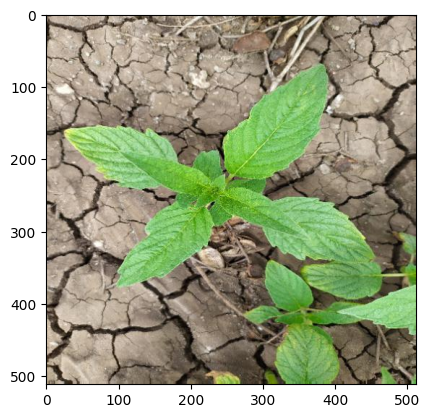

In [ ]:
#checking our conversion is working or not
plt.imshow(cv2.cvtColor(cv2.imread(images[0]),cv2.COLOR_BGR2RGB))

In [ ]:
df = pd.DataFrame(columns=['image_name','object','x_cen','y_cen','w','h'])
i=0
for id in tqdm(images):
    label = open(id[:-5]+'.txt','r')
    a = label.read()
    label.close()
    label = a.split('\n')
    cleaned_label = label[:-1]

    for name in cleaned_label:
        ind_label = name.split(' ')
        df.loc[i,'image_name'] = id[78:]
        df.loc[i,'object'] = int(ind_label[0])
        df.loc[i,'x_cen'] = float(ind_label[1])
        df.loc[i,'y_cen'] = float(ind_label[2])
        df.loc[i,'w'] = float(ind_label[3])
        df.loc[i,'h'] = float(ind_label[4])
        i += 1


100%|██████████| 1300/1300 [00:01<00:00, 736.35it/s]


In [ ]:
df.head()

,image_name,object,x_cen,y_cen,w,h
0,agri_0_4226.jpeg,0,0.46582,0.4375,0.849609,0.640625
1,agri_0_1028.jpeg,0,0.476562,0.285156,0.070312,0.0625
2,agri_0_1028.jpeg,0,0.480469,0.169922,0.054688,0.082031
3,agri_0_1028.jpeg,0,0.148438,0.235352,0.070312,0.091797
4,agri_0_1028.jpeg,0,0.420898,0.489258,0.064453,0.041016


# Converting dataframe into Pascal-voc format

In [ ]:
#column name for pascal-voc dataframe
column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']

In [ ]:
pascal_voc = pd.DataFrame(columns=column_name)
for i in tqdm(range(len(df))):

    pascal_voc.loc[i,'filename'] = df.loc[i,'image_name']
    pascal_voc.loc[i,'width'] = 512
    pascal_voc.loc[i,'height']= 512
    if df.loc[i,'object'] == 0:
        pascal_voc.loc[i,'class'] = 'crop'
    else:
        pascal_voc.loc[i,'class'] = 'weed'
    pascal_voc.loc[i,'xmin']  = int((df.loc[i,'x_cen'] - df.loc[i,'w']/2)*512)
    pascal_voc.loc[i,'ymin']  = int((df.loc[i,'y_cen'] - df.loc[i,'h']/2)*512)
    pascal_voc.loc[i,'xmax']  = int((df.loc[i,'x_cen'] + df.loc[i,'w']/2)*512)
    pascal_voc.loc[i,'ymax']  = int((df.loc[i,'y_cen'] + df.loc[i,'h']/2)*512)


100%|██████████| 2072/2072 [00:01<00:00, 1046.88it/s]


In [ ]:
pascal_voc

,filename,width,height,class,xmin,ymin,xmax,ymax
0,agri_0_4226.jpeg,512,512,crop,20,60,455,388
1,agri_0_1028.jpeg,512,512,crop,225,129,261,161
2,agri_0_1028.jpeg,512,512,crop,232,66,260,108
3,agri_0_1028.jpeg,512,512,crop,58,97,94,144
4,agri_0_1028.jpeg,512,512,crop,198,240,231,261
...,...,...,...,...,...,...,...,...
2067,agri_0_838.jpeg,512,512,crop,28,25,476,440
2068,agri_0_838.jpeg,512,512,crop,20,94,161,211
2069,agri_0_6258.jpeg,512,512,weed,109,132,415,373
2070,agri_0_6258.jpeg,512,512,weed,327,413,415,509


# Visualizing labels

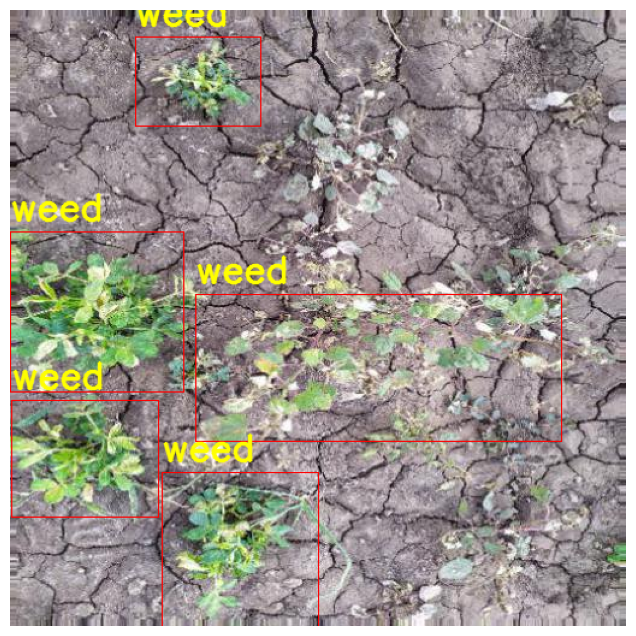

In [ ]:
any_index_number = 55 #change this number for different images
test_img = cv2.cvtColor(cv2.imread(path+pascal_voc.loc[any_index_number,'filename']),cv2.COLOR_BGR2RGB)
test_df = pascal_voc[pascal_voc['filename']==pascal_voc.loc[any_index_number,'filename']].reset_index(drop=True)
for i in range(len(test_df)):

    rec = cv2.rectangle(test_img, (test_df.loc[i,'xmin'],test_df.loc[i,'ymin']), (test_df.loc[i,'xmax'],test_df.loc[i,'ymax']), (255,0,0), 1, 1)
    text = cv2.putText(rec, test_df.loc[i,'class'], (test_df.loc[i,'xmin'],test_df.loc[i,'ymin']-10), cv2.FONT_HERSHEY_SIMPLEX,1, (255,255,0), 2, cv2.LINE_AA)

plt.figure(figsize=(8,8))
plt.imshow(text)
plt.axis('off')
plt.show()

# Saving label file

In [ ]:

pascal_voc.to_csv('pascal_voc_format.csv',index=False)